# Improving predictive models using non-spherical Gaussian priors
Based on the CNN abstract of [Nunez-Elizalde, Huth, & Gallant](https://www2.securecms.com/CCNeuro/docs-0/5928d71e68ed3f844e8a256f.pdf).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.linalg import toeplitz
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tqdm import tqdm_notebook
%matplotlib inline

First, let's generate some data with 100 ($N$) samples and 750 ($K$) features. We'll generate the true parameters ($\beta$), for which we'll calculate the covariance matrix ($C$). 

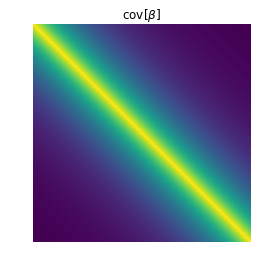

In [118]:
N, K = 100, 500
X = np.random.normal(0, 1, (N, K))
X = np.c_[np.ones(N), X]

mu_betas = np.zeros(K+1)
cov_betas = 0.99**toeplitz(np.arange(0, K+1))
betas = np.random.multivariate_normal(mu_betas, cov_betas).T
C = cov_betas

plt.imshow(cov_betas)
plt.axis('off')
plt.title(r'$\mathrm{cov}[\beta]$')
plt.show()

noise = np.random.normal(0, 1, size=N)
y = X.dot(betas) + noise

### Standard linear regression (no regularization)

In [84]:
folds = KFold(n_splits=10)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

scores = np.zeros(10)
for i, (train_idx, test_idx) in enumerate(folds.split(X, y)):
    pipe.fit(X[train_idx], y[train_idx])
    scores[i] = pipe.score(X[test_idx], y[test_idx])

print(scores, end='\n\n')
print("R: %3f. (%.3f)" % (scores.mean(), scores.std()))

[ 0.00146098 -1.26386231 -0.81397162 -0.17173912  0.17675119 -0.4835256
 -0.23127051  0.10100828  0.09224479  0.51557766]

R: -0.207733. (0.496)


### Ridge

In [164]:
folds = KFold(n_splits=10)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100, 1000]))
])

scores = np.zeros(10)
for i, (train_idx, test_idx) in enumerate(folds.split(X, y)):
    pipe.fit(X[train_idx], y[train_idx])
    preds = pipe.predict(X[test_idx])
    scores[i] = pipe.score(X[test_idx], y[test_idx])

print(scores, end='\n\n')
print("R: %3f. (%.3f)" % (scores.mean(), scores.std()))

[ 0.36829096 -0.64184433  0.02503782 -0.42057347  0.04598201  0.24203902
  0.31045416  0.28774166  0.51904358  0.40496347]

R: 0.114113. (0.356)


### Tikhonov
The traditional solution for Tikhonov regression, for any design matrix $X$ and reponse vector $y$, is usually written as follows:

\begin{align}
\hat{\beta} = (X^{T}X + \lambda C^{T}C)^{-1}X^{T}y
\end{align}

in which $C$ represents the penalty matrix and $\lambda$ the regularization parameter. In this formulation, the prior on the model is that $\beta$ is distributed with zero mean and $(\lambda C^{T}C)^{-1}$ covariance. Alternatively, the estimation of the parameters ($\beta$) can be written as:

\begin{align}
\hat{\beta} = C^{-1}(A^{T}A + \lambda I)^{-1}X^{T}y
\end{align}

with $A$ defined as:

\begin{align}
A = XC^{-1}
\end{align}

Let's define a scikit-learn style class for generic Tikhonov regression:

In [165]:
from sklearn.base import BaseEstimator, RegressorMixin

class Tikhonov(BaseEstimator, RegressorMixin):
    
    def __init__(self, C, lambd=1.):
        self.C = C
        self.lambd = lambd
        
    def fit(self, X, y, sample_weight=None):
        C = self.C
        var_beta = C#np.linalg.inv(C)
        self.coef_ = np.linalg.inv(X.T.dot(X) + self.lambd*var_beta).dot(X.T).dot(y)
        return self

    def predict(self, X, y=None):
        return X.dot(self.coef_)

Now, let's run our (cross-validated) Tikhonov regression:

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


[ 0.32944335 -0.55717775  0.06132024 -0.40716058  0.05440933  0.24783417
  0.30664627  0.28990308  0.43979166  0.39932874]

R2: 0.116434. (0.324)


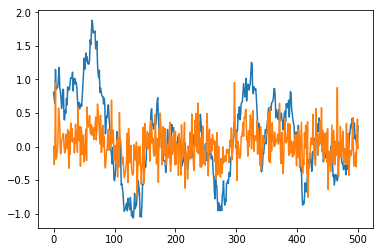

In [174]:
from sklearn.model_selection import GridSearchCV

folds = KFold(n_splits=10)
gs = GridSearchCV(estimator=Tikhonov(C=cov_betas), param_grid=dict(lambd=[0.01, 0.1, 1, 10, 100, 1000]))

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', gs)
])

scores = np.zeros(10)
for i, (train_idx, test_idx) in tqdm_notebook(enumerate(folds.split(X, y))):

    pipe.fit(X[train_idx], y[train_idx])
    preds = pipe.predict(X[test_idx])
    scores[i] = pipe.score(X[test_idx], y[test_idx])

print(scores, end='\n\n')
print("R2: %3f. (%.3f)" % (scores.mean(), scores.std()))

plt.plot(betas)
plt.plot(gs.best_estimator_.coef_)

For some reason, I don't get the same output when I use the alternative ("fast") solution for the $\beta$ parameters (i.e. the one using $A = XC^{-1}$):

In [ ]:
betas_slow = np.linalg.inv(X.T.dot(X) + lambd * np.linalg.inv(C.T.dot(C))).dot(X.T).dot(y)

C_inv = np.linalg.inv(C)
A = X.dot(C_inv)
I = np.eye(X.shape[1])
betas_fast = C_inv.dot(np.linalg.inv(A.T.dot(A) + lambd * I)).dot(A.T).dot(y)

plt.subplot(1, 2, 1)
plt.plot(betas_slow)
plt.title("'Slow' method")
plt.subplot(1, 2, 2)
plt.plot(betas_fast)
plt.title("'Fast' method")
plt.tight_layout()

I do, however, get the same output as the 'slow' method if I don't use the inverse, but the "matrix square root" (function: `sqrtm` from the `scipy.linalg` module) of $C$\*:

\begin{align}
\hat{\beta} = C^{1/2}(A^{T}A + \lambda I)^{-1}X^{T}y
\end{align}

with $A$ defined as:

\begin{align}
A = XC^{1/2}
\end{align}

This method, however, is *much* slower than the traditional implementation.

---
\* Based on the [Github gist](https://gist.github.com/kingjr/926005eb0fba258c4ff380684cb0962b) by Jean-Rémi King.

In [ ]:
from scipy.linalg import sqrtm

C_sqrtm = np.real(sqrtm(C))
An = X.dot(C_sqrtm)
betas_sqrtm = C_sqrtm.dot(np.linalg.inv(An.T.dot(An) + lambd * I)).dot(An.T).dot(y)

plt.subplot(1, 2, 1)
plt.plot(betas_slow)
plt.title("'Slow' method")
plt.subplot(1, 2, 2)
plt.plot(betas_sqrtm)
plt.title("'Sqrtm' method")
plt.tight_layout()